In [46]:
import json
import ast
import plotly.graph_objs as go
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tabulate import tabulate

***************************************************************************************************************
### Research question Q5 : How does the critical reception and recognition of movies with explicit socio-political content compare to those focused on entertainment or aesthetics?
***************************************************************************************************************

Combining quantitative analysis of movie ratings, we aim to uncover patterns in critical reception, exploring whether movies with socio-political underpinnings receive different levels of critical acclaim and recognition compared to those with a more entertainment-oriented or aesthetic focus.

In [47]:
df = pd.read_csv('df_with_emotions.csv')

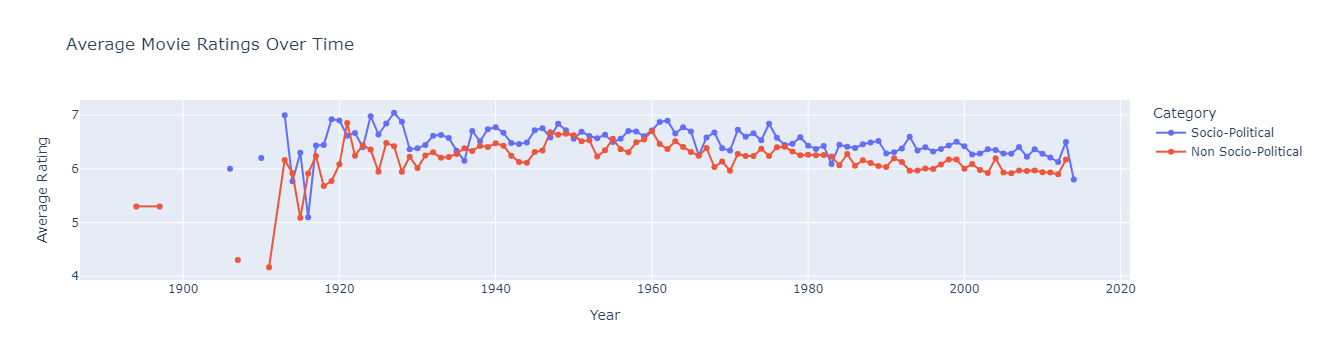

In [53]:
#*****************************************************************************************************************
#Trend Analysis Over Time: Analyze how the critical reception of movies in the Socio-political and Non Socio-Political categories has changed over time.
#*****************************************************************************************************************

# Group by ReleaseYear and Category, then calculate the mean rating for each group
mean_ratings_over_time = df.groupby(['MovieReleaseDate', 'Category'])['averageRating'].mean().unstack().reset_index()

# Plotting with Plotly Graph Objects
trace_socio_political = go.Scatter(x=mean_ratings_over_time['MovieReleaseDate'], y=mean_ratings_over_time['Socio-Political'],
                                   mode='lines+markers', name='Socio-Political')

trace_non_socio_political = go.Scatter(x=mean_ratings_over_time['MovieReleaseDate'], y=mean_ratings_over_time['Non Socio-Political'],
                                       mode='lines+markers', name='Non Socio-Political')

data = [trace_socio_political, trace_non_socio_political]

layout = go.Layout(
    title='Average Movie Ratings Over Time',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Average Rating'),
    legend=dict(title='Category'),
)

fig = go.Figure(data=data, layout=layout)

fig_json = fig.to_json()
with open('figure_state.json', 'w') as json_file:
    json_file.write(fig_json)
# Show the plot
fig.show()

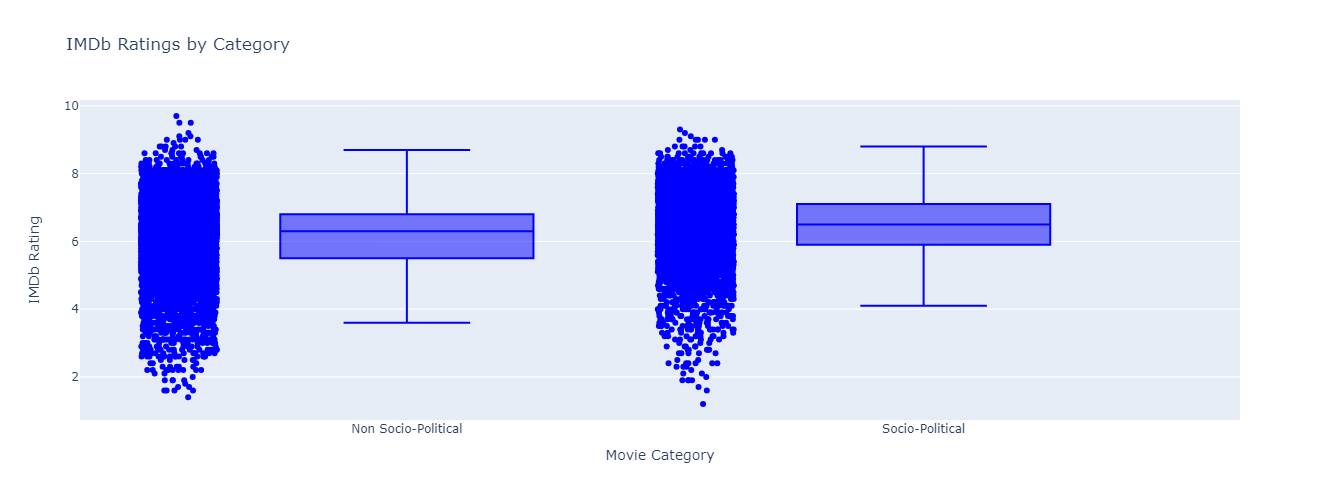

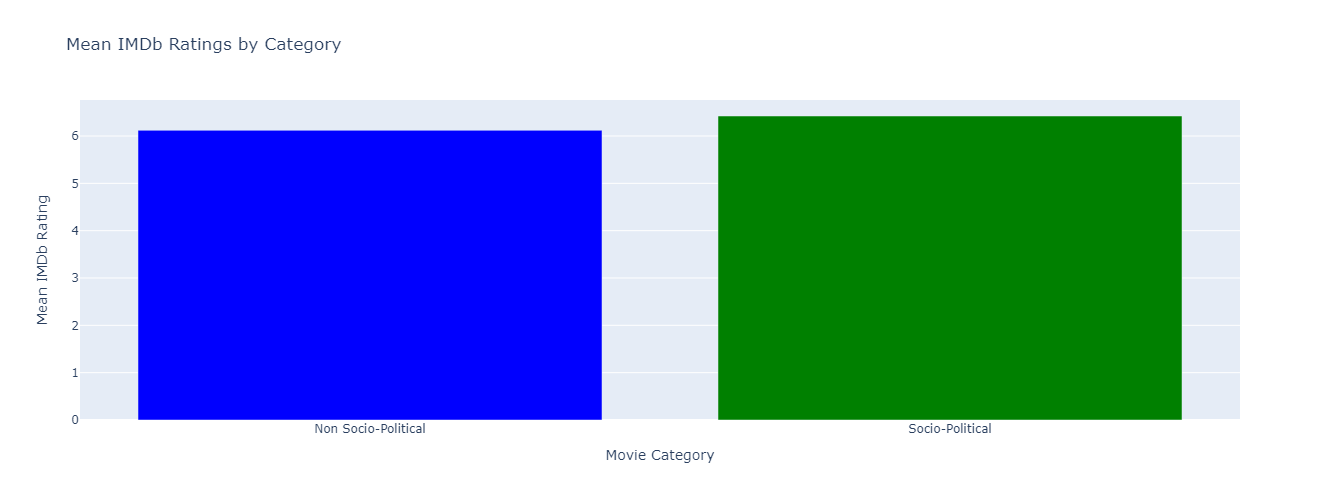

T-Statistic: 17.59321774338521
P-Value: 1.4422005814349149e-68
The difference in IMDb ratings is statistically significant.
              Category  Mean IMDb Rating  Standard Deviation IMDb Rating
0      Socio-Political          6.422895                        1.010366
1  Non Socio-Political          6.120137                        1.084352
╒═════════════════════╤════════════════════╤══════════════════════════════════╕
│ Category            │   Mean IMDb Rating │   Standard Deviation IMDb Rating │
╞═════════════════════╪════════════════════╪══════════════════════════════════╡
│ Socio-Political     │            6.42289 │                          1.01037 │
├─────────────────────┼────────────────────┼──────────────────────────────────┤
│ Non Socio-Political │            6.12014 │                          1.08435 │
╘═════════════════════╧════════════════════╧══════════════════════════════════╛


In [54]:
# Separate movies into two categories
socio_political_movies = df[df['Category'] == 'Socio-Political']
non_socio_political_movies = df[df['Category'] == 'Non Socio-Political']

# Create box plots to visualize IMDb ratings for each category
box_trace = go.Box(
    x=df['Category'],
    y=df['averageRating'],
    name='IMDb Ratings',
    boxpoints='all',
    jitter=0.3,
    pointpos=-1.8,
    marker=dict(color='blue'),
)

box_layout = go.Layout(
    title='IMDb Ratings by Category',
    xaxis=dict(title='Movie Category'),
    yaxis=dict(title='IMDb Rating'),
    width=800,
    height=500,
)

box_fig = go.Figure(data=[box_trace], layout=box_layout)

# Group the data by category and calculate the mean IMDb rating for each category
category_means = df.groupby('Category')['averageRating'].mean().reset_index()

# Create a bar chart to visualize mean IMDb ratings by category
bar_trace = go.Bar(
    x=category_means['Category'],
    y=category_means['averageRating'],
    marker=dict(color=['blue', 'green']),
)

bar_layout = go.Layout(
    title='Mean IMDb Ratings by Category',
    xaxis=dict(title='Movie Category'),
    yaxis=dict(title='Mean IMDb Rating'),
    width=600,
    height=500,
)

bar_fig = go.Figure(data=[bar_trace], layout=bar_layout)

bar_fig = go.Figure(data=[bar_trace], layout=bar_layout)

# Convert the bar chart figure to JSON
bar_fig_json = bar_fig.to_json()
with open('bar_chart_figure.json', 'w') as json_file:
    json_file.write(bar_fig_json)
    
# Display the box plot and bar chart
box_fig.show()
bar_fig.show()


# Perform a t-test to compare IMDb ratings
t_statistic, p_value = stats.ttest_ind(socio_political_movies['averageRating'], non_socio_political_movies['averageRating'], equal_var=False)

# Print the results of the t-test
print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

# Determine if the difference is statistically significant
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print('The difference in IMDb ratings is statistically significant.')
else:
    print('There is no statistically significant difference in IMDb ratings.')

# Print the means and standard deviations for each category
mean_socio_political = socio_political_movies['averageRating'].mean()
mean_non_socio_political = non_socio_political_movies['averageRating'].mean()
std_socio_political = socio_political_movies['averageRating'].std()
std_non_socio_political = non_socio_political_movies['averageRating'].std()

"""print(f'Mean IMDb Rating (Socio-Political): {mean_socio_political}')
print(f'Mean IMDb Rating (Non Socio-Political): {mean_non_socio_political}')
print(f'Standard Deviation IMDb Rating (Socio-Political): {std_socio_political}')
print(f'Standard Deviation IMDb Rating (Non Socio-Political): {std_non_socio_political}')"""

data = {
    'Category': ['Socio-Political', 'Non Socio-Political'],
    'Mean IMDb Rating': [mean_socio_political, mean_non_socio_political],
    'Standard Deviation IMDb Rating': [std_socio_political, std_non_socio_political]
}

results_table = pd.DataFrame(data)

# Display the DataFrame
print(results_table)

table_data = [
    ['Category', 'Mean IMDb Rating', 'Standard Deviation IMDb Rating'],
    ['Socio-Political', mean_socio_political, std_socio_political],
    ['Non Socio-Political', mean_non_socio_political, std_non_socio_political]
]

# Display the table
print(tabulate(table_data, headers='firstrow', tablefmt='fancy_grid'))

In the dynamic landscape of the film industry, the exploration of how explicit socio-political content in movies compares to those emphasizing entertainment or aesthetics has become an increasingly pertinent area of inquiry. In this part, we want to unravel the nuanced interplay between critical reception and recognition in movies, aiming to discern whether movies addressing socio-political themes resonate differently with audiences compared to those designed that are non socio-political.

The research question at the core of this investigation is: "How does the critical reception and recognition of movies with explicit socio-political content compare to those focused on entertainment or aesthetics?" To answer this question, a comprehensive analysis was undertaken, considering a range of factors, from average ratings to standard deviations, with the ultimate goal of uncovering patterns and trends that illuminate the distinct nature of these two categories.

The statistical results yielded a compelling T-Statistic of 17.59 and an extremely low P-Value of 1.44e-68, indicating a statistically significant difference in IMDb ratings between movies with explicit socio-political content and those emphasizing entertainment or aesthetics. This substantial T-Statistic emphasizes the magnitude of the observed difference.

Further insight into the ratings reveals that movies with explicit socio-political content, on average, received a mean IMDb rating of 6.42, while those in the entertainment or aesthetics category had a slightly lower mean rating of 6.12. The standard deviation for socio-political movies (1.01) was also marginally lower than that of non socio-political movies (1.08).

This discovery opens a gateway to a deeper understanding of audience preferences, critical evaluations, and the potential impact of socio-political narratives on the movies landscape. The statistically significant difference in ratings not only highlights a preference for socio-political content but also suggests a higher level of consensus among viewers regarding the quality of movies in this genre.

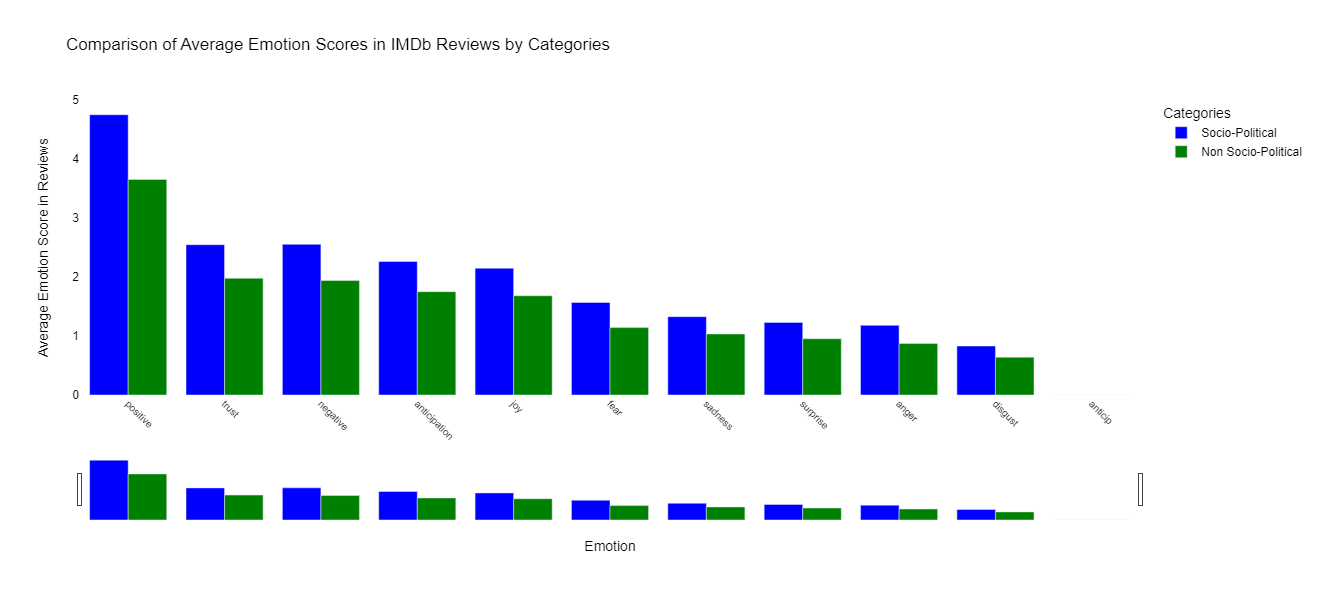

In [76]:
import plotly.graph_objs as go
import pandas as pd
import ast

# Your function definitions...

# Calculate average emotions for each category
avg_emotions_socio_political = calculate_average_emotions(socio_political_df)
avg_emotions_non_socio_political = calculate_average_emotions(non_socio_political_df)

# Combine and sort emotions based on their average scores
combined_avg_emotions = {emotion: (avg_emotions_socio_political.get(emotion, 0) + avg_emotions_non_socio_political.get(emotion, 0)) / 2 for emotion in set(avg_emotions_socio_political).union(avg_emotions_non_socio_political)}
sorted_emotions = sorted(combined_avg_emotions, key=combined_avg_emotions.get, reverse=True)

# Data for socio-political and non-socio-political
socio_political_data = [avg_emotions_socio_political.get(emotion, 0) for emotion in sorted_emotions]
non_socio_political_data = [avg_emotions_non_socio_political.get(emotion, 0) for emotion in sorted_emotions]

# Adding traces
fig_emotions = go.Figure()
fig_emotions.add_trace(go.Bar(
    name='Socio-Political',
    x=sorted_emotions,
    y=socio_political_data,
    marker_color='blue'
))

fig_emotions.add_trace(go.Bar(
    name='Non Socio-Political',
    x=sorted_emotions,
    y=non_socio_political_data,
    marker_color='green'
))

# Update the layout for a cleaner look
fig_emotions.update_layout(
    title='Comparison of Average Emotion Scores in IMDb Reviews by Categories',
    xaxis=dict(
        title='Emotion',
        automargin=True,
        tickangle=45,
        tickmode='linear',
        tickfont=dict(size=10),
        rangeslider=dict(visible=True)
    ),
    yaxis=dict(title='Average Emotion Score in Reviews', automargin=True),
    barmode='group',
    legend_title='Categories',
    plot_bgcolor='white',
    font=dict(family="Arial, sans-serif", size=12, color="black"),
    legend=dict(y=1, yanchor='top'),
    autosize=False,
    width=1000,
    height=600
)

fig_emotions_json = fig_emotions.to_json()
with open('bar_emotions_figure.json', 'w') as json_file:
    json_file.write(fig_emotions_json)

fig_emotions.show()


The comprehensive analysis of emotions in IMDb reviews presents an intriguing narrative about the reception of movies. It reveals that while the same spectrum of emotions is present in both socio-political and non-socio-political movies, socio-political movies tend to evoke stronger emotional responses, as evidenced by higher emotion scores in their reviews.

This distinction in emotional intensity highlights the profound impact socio-political content can have on viewers. Movies that delve into social and political themes often resonate more deeply with their audiences, possibly due to their relevance to real-world issues, their reflection of societal challenges, or their commentary on significant global events. These movies not only entertain but also engage viewers on a more intense emotional level, stirring a more passionate and thoughtful reaction.

The heightened emotional engagement in socio-political films can be seen as a testament to their power to connect with audiences on matters that extend beyond the realms of mere entertainment. These films often offer insights into complex human experiences and societal dynamics, eliciting a range of emotions from empathy and outrage to inspiration and hope.

Interestingly, the fact that non-socio-political movies evoke a similar range of emotions, albeit at a lower intensity, suggests that cinematic storytelling, in general, has a universal appeal and capacity to elicit emotional responses. This underscores the power of film as a medium to not only depict diverse stories but also to touch upon the human condition in various ways, regardless of the genre or theme.

In conclusion, our analysis underscores the unique position of socio-political movies in evoking stronger emotional reactions among viewers. This finding highlights the role of these movies in not just entertaining, but also in engaging audiences in more profound and meaningful ways, often leaving a lasting impression and contributing to ongoing societal dialogues.